In [1]:
import numpy as np
import pandas as pd
import scipy
import networkx as nx
import requests
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.optimize import curve_fit

from markov_epidemic import *

### Load French Covid data


Note how spiky the measured positive rate is. The spikes correspond exactly to drops in the number of tests performed (which coincides with the week-end). Therefore the spikes are likely a combination of 1) statistical noise (less data points so more variance) and 2) sampling bias (only people with severe symptoms are tested during the week-ends).

In order to compare with the simulation, the positive rate is smoothed to flatten these spiky artefacts.

In [2]:
url = 'https://static.data.gouv.fr/resources/donnees-relatives-aux-tests-de-depistage-de-covid-19-realises-en-laboratoire-de-ville/20200422-190016/donnees-tests-covid19-labo-quotidien-2020-04-22-19h00.csv'
file = requests.get(url)
filename = 'test_covid.csv'
open(filename, 'wb').write(file.content)
df = pd.read_csv(filename, sep=';')

df = df.groupby(by=['jour']).sum()
df['pos_rate'] = df['nb_pos'] / df['nb_test']

taux_pos_smooth = savgol_filter(df['pos_rate'], 21, 3)

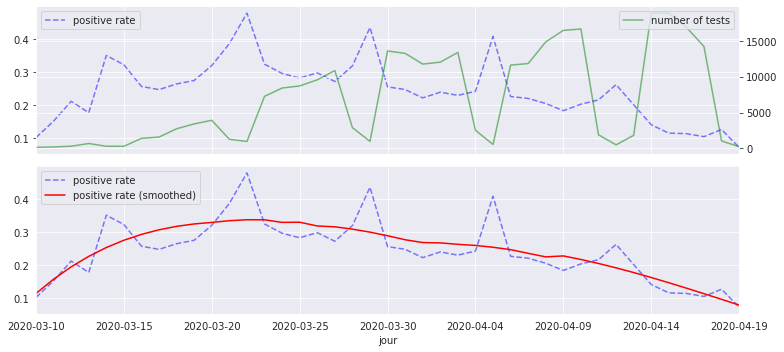

In [3]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(11, 5), nrows=2, ncols=1)
    
    ax1 = axes[0]
    df['pos_rate'].plot(
        ax=ax1,
        color='b', 
        label='positive rate', 
        linestyle='dashed',
        alpha=0.5
    )
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    df['nb_test'].plot(
        ax=ax2,
        color='g',
        label='number of tests',
        alpha=0.5
    )
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    ax = axes[1]       
    df['pos_rate'].plot(ax=ax, 
                        color='b', 
                        label='positive rate', 
                        linestyle='dashed',
                        alpha=0.5)
    ax.plot(df.index, taux_pos_smooth, color='r', label='positive rate (smoothed)')

    ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

### Network type

Preferential attachment network, the parameter $m$ controls the number of new links in the attachment mechanism (the higher $m$, the more connected).

Feel free to change the value of $m$ or even test different types of networks.
For instance, increase the connectivity of the network should result in a dramatic increase of the number of infected individuals.

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


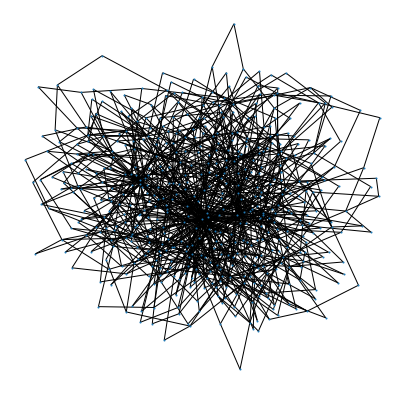

In [4]:
N = 500
m = 2
G = nx.barabasi_albert_graph(N, m)

# save layout
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.axis('off')

plt.show()

## SEIR Epidemic

Consider a network $\mathcal{G}$ of $N$ individuals subject to an epidemic disease.
Let $A$ be the adjacency matrix of the underlying graph and $X_i(t)$ the health state of individual $i$ at time $t$.

We assume the following random Markov dynamic:

$$
\begin{cases} 
      \text{healthy} \rightarrow \text{exposed} & \text{at rate $\beta\sum_j A_{ij} \mathbb{1}_{X_j(t) = \text{infected}}$,}  \\
      \text{exposed} \rightarrow \text{infected} & \text{at rate $\gamma$.} \\
      \text{infected} \rightarrow \text{recovered} & \text{at rate $\delta$.} \\
   \end{cases}
$$

In other words, susceptible individuals are contaminated at a rate proportional to the number of infected neighbors in the network, then they undergo an incubation period at rate $\gamma$ during which they carry the disease but are not showing symptoms, and then recover at constant rate $\delta$. Once an individual has recovered it can never be infected again. Also we assume only one individual can change state at a given time $t$ (the events of multiple simultaneous transitions have probability zero anyway).

This is the **Susceptible-Exposed-Infected-Recovered (SEIR)** model.

### Epidemic parameters

In [5]:
exposition_rate = 0.08
infection_rate = 0.005
recovery_rate = 0.05
epidemic = MarkovSEIR(exposition_rate, infection_rate, recovery_rate, G)

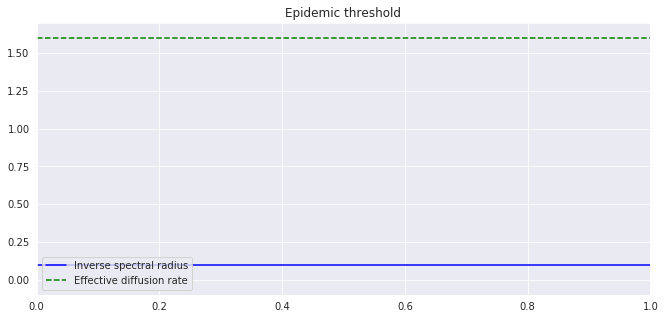

In [6]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(11, 5), nrows=1, ncols=1)

    isr = 1/epidemic.spectral_radius
    edr = epidemic.effective_diffusion_rate
    
    ax.axhline(y=isr, color='b', label='Inverse spectral radius')
    ax.axhline(y=edr, color='g', label='Effective diffusion rate', linestyle='dashed')

    ax.set_xlim(0, 1)
    ax.set_ylim(np.min((edr, isr))-0.2, np.max((edr, isr))+0.1)
    ax.set_title('Epidemic threshold')
    ax.legend(loc='lower left')

    plt.show()

In [7]:
T = 500.0
initial_infected = int(df.iloc[0]['pos_rate'] * N)
epidemic.simulate(T, epidemic.random_seed_nodes(initial_infected))

/home/sauxpa/github/markov_epidemic/markov_epidemic/markov_epidemic/markov_epidemic.py:251: RuntimeWarning: divide by zero encountered in true_divide
  holding_times = np.random.exponential(scale=1/rates)


In [8]:
tt = np.linspace(0, np.max(epidemic.transition_times), len(df.index))
taux_pos_interp = interp1d(tt,
                           taux_pos_smooth,
                           fill_value='extrapolate',
                           kind='linear',
                           )

### Plot comparison

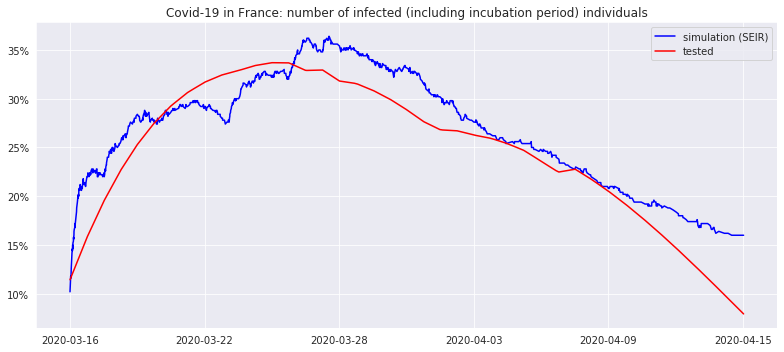

In [12]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(11, 5), nrows=1, ncols=1)

    # Trick to show both real and simulated data on the same time scale
    skip = int(np.floor(len(df.index)/np.max(epidemic.transition_times)))
    ax.set_xticklabels(df.index[::6])
    
    ax.plot(
        epidemic.transition_times, 
        (epidemic.number_of_infected + epidemic.number_of_exposed)/ epidemic.N, 
        color='b', 
        label='simulation (SEIR)'
    )
    
    ax.plot(
        epidemic.transition_times, 
        taux_pos_interp(epidemic.transition_times), 
        color='r', 
        label='tested'
    )
    
    ax.set_title('Covid-19 in France: number of infected (including incubation period) individuals')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()